## Hopfield Networks
Hopfield networks were first introduced by W. A. Little in 1974, then popularized by J. Hopfield in 1982. They are associative memory networks: you first teach them some patterns, and then when they see a new pattern they (hopefully) output the closest learned pattern. This made them useful for character recognition, in particular, before they were outperformed by other approaches: you first train the network by showing it examples of character images (each binary pixel maps to one neuron), and then when you show it a new character image, after a few iterations it outputs the closest learned character.

Hopfield networks are fully connected graphs (see figure 1 below); that is, every neuron is connected to every other neuron. Note that in the diagram the images are 6 × 6 pixels, so the neural network on the left should contain 36 neurons (and 630 connections), but for visual clarity a much smaller network is represented.

**Figure 1**: _Hopfield network_
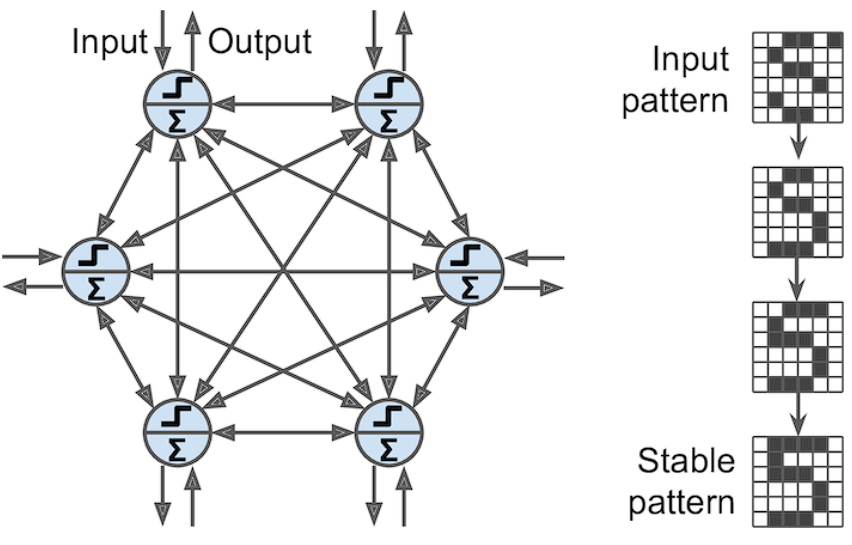

The training algorithm works by using Hebb's rule (see the section about Perceptrons in chapter 10): for each training image, the weight between two neurons is increased if the corresponding pixels are both on or both off, but decreased if one pixel is on and the other is off.

To show a new image to the network, you just activate the neurons that correspond to active pixels. The network then computes the output of every neuron, and this gives you a new image. You can then take this new image and repeat the whole process. After a while, the network reaches a stable state. Generally, this corresponds to the training image that most resembles the input image.

A so-called _energy function_ is associated with Hopfield nets. At each iteration, the energy decreases, so the network is guaranteed to eventually stabilize to a low-energy state. The training algorithm tweaks the weights in a way that decreases the energy level of the training patterns, so the network is likely to stabilize in one of these low-energy configurations. Unfortunately, some patterns that were not in the training set also end up with low energy, so the network sometimes stabilizes in a configuration that was not learned. These are called _spurious patterns_.

Another major flaw with Hopfield nets is that they don't scale very well–their memory capacity is roughly equal to 14% of the number of neurons. For example, to classify 28 × 28–pixel images, you would need a Hopfield net with 784 fully connected neurons and 306,936 weights. Such a network would only be able to learn about 110 different characters (14% of 784). That's a lot of parameters for such a small memory.


## Boltzmann Machines

_Boltzmann machines_ were invented in 1985 by Geoffrey Hinton and Terrence Sejnowski. Just like Hopfield nets, they are fully connected ANNs, but they are based on _stochastic neurons_: instead of using a deterministic step function to decide what value to output, these neurons output 1 with some probability, and 0 otherwise. The probability function that these ANNs use is based on the Boltzmann distribution (used in statistical mechanics), hence their name. See equation 1.

**Equation 1**: _probability that a particular neuron will output 1_
$$P(s_i^\text{next step}=1) = \sigma\left(\dfrac{\sum_{j=1}^N{w_{i,j}s_j + b_i}}{T}\right)$$

* $s_j$ is the $j^\text{th}$ neuron's state (0 or 1).
* $w_{i,j}$ is the connection weight between the $i^\text{th}$ and $j^\text{th}$ neurons. Note that $w_{i,i}$ = 0.
* $b_i$ is the $i^\text{th}$ neuron's bias term. We can implement this term by adding a bias neuron to the network.
* _N_ is the number of neurons in the network.
* _T_ is a number called the network's _temperature_; the higher the temperature, the more random the output is (i.e., the more the probability approaches 50%).
* $\sigma$ is the logistic function.

Neurons in Boltzmann machines are separated into two groups: _visible units_ and _hidden units_ (see figure 2). All neurons work in the same stochastic way, but the visible units are the ones that receive the inputs and from which outputs are read.

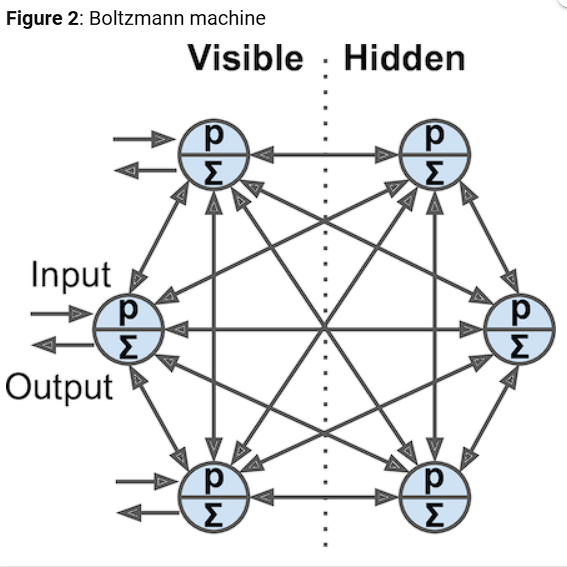

Because of its stochastic nature, a Boltzmann machine will never stabilize into a fixed configuration; instead, it will keep switching between many configurations. If it is left running for a sufficiently long time, the probability of observing a particular configuration will only be a function of the connection weights and bias terms, not of the original configuration (similarly, after you shuffle a deck of cards for long enough, the configuration of the deck does not depend on the initial state). When the network reaches this state where the original configuration is "forgotten," it is said to be in _thermal equilibrium_ (although its configuration keeps changing all the time). By setting the network parameters appropriately, letting the network reach thermal equilibrium, and then observing its state, we can simulate a wide range of probability distributions. This is a type of _generative model_.

Training a Boltzmann machine means finding the parameters that will make the network approximate the training set's probability distribution. For example, if there are three visible neurons and the training set contains 75% (0, 1, 1) triplets, 10% (0, 0, 1) triplets, and 15% (1, 1, 1) triplets, then after training a Boltzmann machine, you could use it to generate random binary triplets with about the same probability distribution. For example, about 75% of the time it would output the (0, 1, 1) triplet.

Such a generative model can be used in a variety of ways. For example, if it is trained on images, and you provide an incomplete or noisy image to the network, it will automatically "repair" the image in a reasonable way. You can also use a generative model for classification. Just add a few visible neurons to encode the training image's class (e.g., add 10 visible neurons and turn on only the fifth neuron when the training image represents a 5). Then, when given a new image, the network will automatically turn on the appropriate visible neurons, indicating the image's class (e.g., it will turn on the fifth visible neuron if the image represents a 5).

Unfortunately, there is no efficient technique to train Boltzmann machines. However, fairly efficient algorithms have been developed to train _restricted Boltzmann machines_ (RBMs).

## Restricted Boltzmann Machines
An RBM is simply a Boltzmann machine in which there are no connections between visible units or between hidden units, only between visible and hidden units. For example, figure 3 represents an RBM with three visible units and four hidden units.

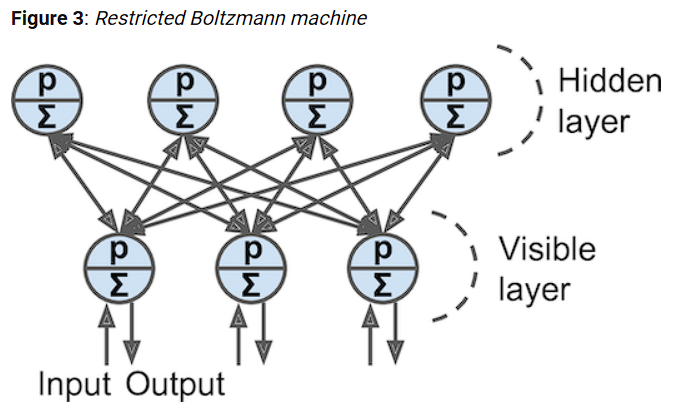

A very efficient training algorithm called [Contrastive Divergence](https://homl.info/135) was introduced in 2005 by Miguel Á. Carreira-Perpiñán and Geoffrey Hinton.

> Reference: Miguel Á. Carreira-Perpiñán and Geoffrey E. Hinton, "On Contrastive Divergence Learning," _Proceedings of the 10th International Workshop on Artificial Intelligence and Statistics_ (2005): 59–66.

Here is how it works: for each training instance **x**, the algorithm starts by feeding it to the network by setting the state of the visible units to _x_<sub>1</sub>, _x_<sub>2</sub>, ..., _x_<sub>_n_</sub>. Then you compute the state of the hidden units by applying the stochastic equation described above. This gives you a hidden vector **h** (where _h_<sub>_i_</sub> is equal to the state of the _i_<sup>th</sup> unit). Next you compute the state of the visible units, by applying the same stochastic equation. This gives you a vector **xʹ**. Then once again you compute the state of the hidden units, which gives you a vector **hʹ**. Now you can update each connection weight by applying the rule in equation 2, where _η_ is the learning rate.

**Equation 2**: _Contrastive divergence weight update_
$$w_{i,j} \leftarrow w_{i,j} + \eta(\mathbf{xh}^\intercal - \mathbf{x'h'}^\intercal)$$


The great benefit of this algorithm is that it does not require waiting for the network to reach thermal equilibrium: it just goes forward, backward, and forward again, and that's it. This makes it incomparably more efficient than previous algorithms, and it was a key ingredient to the first success of Deep Learning based on multiple stacked RBMs.

## Deep Belief Nets
Several layers of RBMs can be stacked; the hidden units of the first-level RBM serve as the visible units for the second-layer RBM, and so on. Such an RBM stack is called a _deep belief net_ (DBN).

Yee-Whye Teh, one of Geoffrey Hinton's students, observed that it was possible to train DBNs one layer at a time using Contrastive Divergence, starting with the lower layers and then gradually moving up to the top layers. This led to the [groundbreaking article that kickstarted the Deep Learning tsunami in 2006](https://homl.info/136).

> Reference: Geoffrey E. Hinton et al., "A Fast Learning Algorithm for Deep Belief Nets," _Neural Computation_ 18 (2006): 1527–1554.

Just like RBMs, DBNs learn to reproduce the probability distribution of their inputs, without any supervision. However, they are much better at it, for the same reason that deep neural networks are more powerful than shallow ones: real-world data is often organized in hierarchical patterns, and DBNs take advantage of that. Their lower layers learn low-level features in the input data, while higher layers learn high-level features.

Just like RBMs, DBNs are fundamentally unsupervised, but you can also train them in a supervised manner by adding some visible units to represent the labels. Moreover, one great feature of DBNs is that they can be trained in a semisupervised fashion. Figure 4 represents such a DBN configured for semisupervised learning.

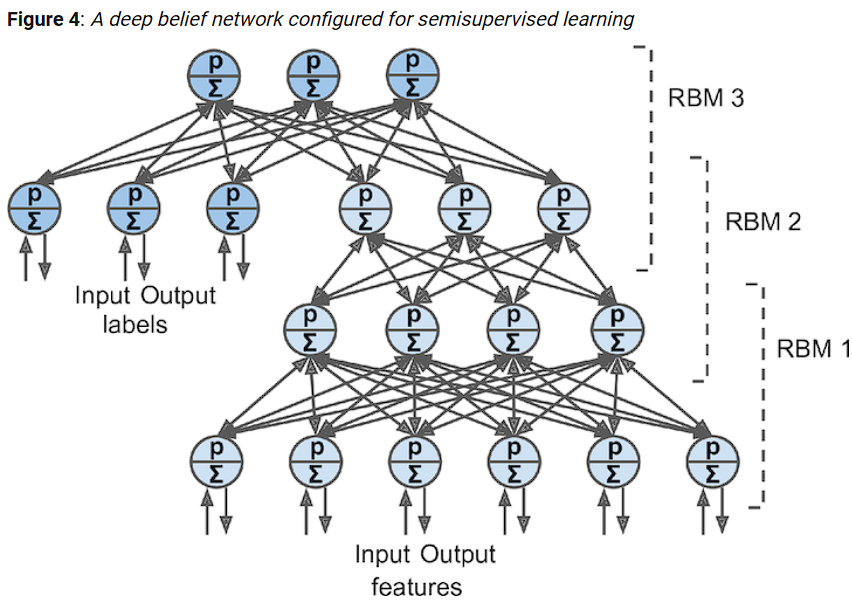

First, RBM 1 is trained without supervision. It learns low-level features in the training data. Then RBM 2 is trained with RBM 1's hidden units as inputs, again without supervision: it learns higher-level features (note that RBM 2's hidden units include only the three rightmost units, not the label units). Several more RBMs could be stacked this way, but you get the idea. So far, training was 100% unsupervised. Lastly, RBM 3 is trained using RBM 2's hidden units as inputs, as well as extra visible units used to represent the target labels (e.g., a one-hot vector representing the instance class). It learns to associate high-level features with training labels. This is the supervised step.

At the end of training, if you feed RBM 1 a new instance, the signal will propagate up to RBM 2, then up to the top of RBM 3, and then back down to the label units; hopefully, the appropriate label will light up. This is how a DBN can be used for classification.

One great benefit of this semisupervised approach is that you don't need much labeled training data. If the unsupervised RBMs do a good enough job, then only a small amount of labeled training instances per class will be necessary. Similarly, a baby learns to recognize objects without supervision, so when you point to a chair and say "chair," the baby can associate the word "chair" with the class of objects it has already learned to recognize on its own. You don't need to point to every single chair and say "chair"; only a few examples will suffice (just enough so the baby can be sure that you are indeed referring to the chair, not to its color or one of the chair's parts).

Quite amazingly, DBNs can also work in reverse. If you activate one of the label units, the signal will propagate up to the hidden units of RBM 3, then down to RBM 2, and then RBM 1, and a new instance will be output by the visible units of RBM 1. This new instance will usually look like  a regular instance of the class whose label unit you activated. This generative capability of DBNs is quite powerful. For example, it has been used to automatically generate captions for images, and vice versa: first a DBN is trained (without supervision) to learn features in images, and another DBN is trained (again without supervision) to learn features in sets of captions (e.g., "car" often comes with "automobile"). Then an RBM is stacked on top of both DBNs and trained with a set of images along with their captions; it learns to associate high-level features in images with high-level features in captions. Next, if you feed the image DBN an image of a car, the signal will propagate through the network, up to the top-level RBM, and back down to the bottom of the caption DBN, producing a caption. Due to the stochastic nature of RBMs and DBNs, the caption will keep changing randomly, but it will generally be appropriate for the image. If you generate a few hundred captions, the most frequently generated ones will likely be a good description of the image (see [this video](https://homl.info/137) by Geoffrey Hinton for more details and a demo).


## Self-Organizing Maps
_Self-organizing maps_ (SOMs) are quite different from all the other types of neural networks we have discussed so far. They are used to produce a low-dimensional representation of a high-dimensional dataset, generally for visualization, clustering, or classification. The neurons are spread across a map (typically 2D for visualization, but it can be any number of dimensions you want), as shown in figure 5, and each neuron has a weighted connection to every input (note that the diagram shows just two inputs, but there are typically a very large number, since the whole point of SOMs is to reduce dimensionality).

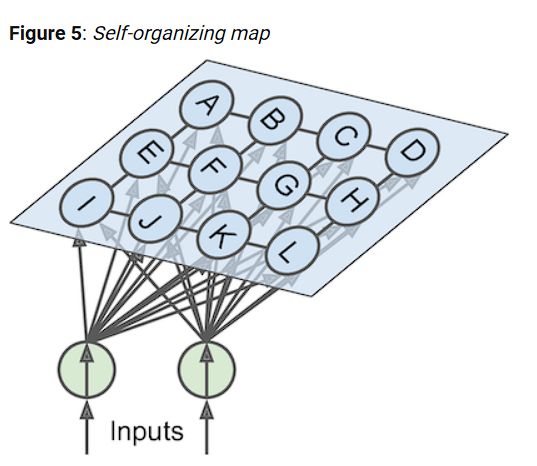

Once the network is trained, you can feed it a new instance and this will activate only one neuron (i.e., one point on the map): the neuron whose weight vector is closest to the input vector. In general, instances that are nearby in the original input space will activate neurons that are nearby on the map. This makes SOMs useful not only for visualization (in particular, you can easily identify clusters on the map), but also for applications like speech recognition. For example, if each instance represents an audio recording of a person pronouncing a vowel, then different pronunciations of the vowel "a" will activate neurons in the same area of the map, while instances of the vowel "e" will activate neurons in another area, and intermediate sounds will generally activate intermediate neurons on the map.

> **Note**: One important difference from the other dimensionality reduction techniques discussed in chapter 8 is that all instances get mapped to a discrete number of points in the low-dimensional space (one point per neuron). When there are very few neurons, this technique is better described as clustering rather than dimensionality reduction.

The training algorithm is unsupervised. It works by having all the neurons compete against each other. First, all the weights are initialized randomly. Then a training instance is picked randomly and fed to the network. All neurons compute the distance between their weight vector and the input vector (this is very different from the artificial neurons we have seen so far). The neuron that measures the smallest distance wins and tweaks its weight vector to be slightly closer to the input vector, making it more likely to win future competitions for other inputs similar to this one. It also recruits its neighboring neurons, and they too update their weight vectors to be slightly closer to the input vector (but they don't update their weights as much as the winning neuron). Then the algorithm picks another training instance and repeats the process, again and again. This algorithm tends to make nearby neurons gradually specialize in similar inputs.

Here's an anology: imagine a class of young children with roughly similar skills. One child happens to be slightly better at basketball. This motivates her to practice more, especially with her friends. After a while, this group of friends gets so good at basketball that other kids cannot compete. But that's okay, because the other kids specialize in other areas. After a while, the class is full of little specialized groups.
